# Training Regression Models on chemical reactions

> Here we show how simple it is to train reaction BERTs on any regression task.

## Available tools

BERT and related transformer models have revolutionised Natural Language Processing. The implementation of such models is conveniently made available through the [Huggingface Transformers](https://github.com/huggingface/transformers) library. We based already based our previous work on reaction fingerprints / classification and atom-mapping on this library. To train the yield regression models in this work, we used the [SimpleTransformers.ai](https://simpletransformers.ai), which contains all you need to add fine-tuning heads on top of transformers, run trainings and evaluations.

## SmilesTokenizer

One key difference compared to human languages, when compared to chemistry are the tokens and tokenizers. In this work, we use the tokenizer introduced our previous [rxnfp](https://rxn4chemistry.github.io/rxnfp/) work with the same regex as in the [Molecular Transformer](https://github.com/pschwllr/MolecularTransformer). 

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


['C', 'C', '(', 'C', ')', '[C@@H]', '(', 'C', ')', 'C', 'C', 'Br', '.', '[Na]', 'C', '#', 'N', '>>', 'C', 'C', '(', '[C@@H]', '(', 'C', ')', 'C', 'C', 'C', '#', 'N', ')', 'C']


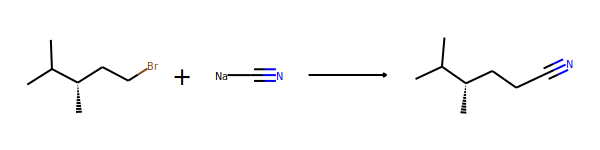

In [8]:
from rxnfp.tokenization import get_default_tokenizer, SmilesTokenizer
from rdkit.Chem import rdChemReactions

smiles_tokenizer = get_default_tokenizer()

reaction_smiles = 'CC(C)[C@@H](C)CCBr.[Na]C#N>>CC([C@@H](C)CCC#N)C'
rxn = rdChemReactions.ReactionFromSmarts(reaction_smiles,useSmiles=True)

print(smiles_tokenizer.tokenize(reaction_smiles))
rxn

As the tokenizer is normally hard-coded in the SimpleTransformers library we need to change it, we therefore create a `SmilesClassificationModel` class, as seen in the `core` module. 

```python
MODEL_CLASSES = {
            "bert": (BertConfig, BertForSequenceClassification, SmilesTokenizer),
        }
```

Once this is done, the SimpleTransformers library can be used as usual. 



## Pretrained reaction BERT models

There are currently two reaction BERT models in the `rxnfp` library - `pretrained` (trained with on a reaction MLM task) and `ft` (additionally trained on a reaction classification task). For this example, we will use the `pretrained` model as starting point for the training of our Yield-BERT. On the Buchwald-Hartwig reactions both base models performed similarly.

In [9]:
import pkg_resources
import torch
from rxnfp.models import SmilesClassificationModel
model_path =  pkg_resources.resource_filename(
                "rxnfp",
                f"models/transformers/bert_pretrained" # change pretrained to ft to start from the other base model
)
yield_bert = SmilesClassificationModel('bert', model_path, use_cuda=torch.cuda.is_available())

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


## Prepare the data

Load the reaction SMILES and yield values into a DataFrame with columns `['text', 'labels']`.

The same procedure could be applied to any reaction (or molecule) regression task.

In [ ]:
# data
import pandas as pd
from rxn_yields.data import generate_buchwald_hartwig_rxns
df = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name='FullCV_01')
df['rxn'] = generate_buchwald_hartwig_rxns(df)

train_df = df.iloc[:2767][['rxn', 'Output']] 
test_df = df.iloc[2767:][['rxn', 'Output']] #

train_df.columns = ['text', 'labels']
test_df.columns = ['text', 'labels']
mean = train_df.labels.mean()
std = train_df.labels.std()
train_df['labels'] = (train_df['labels'] - mean) / std
test_df['labels'] = (test_df['labels'] - mean) / std
train_df.head()

,text,labels
0,CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.COc1...,1.387974
1,Brc1ccccn1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C...,-0.796876
2,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2...,-0.827835
3,CCOC(=O)c1cnoc1.CN1CCCN2CCCN=C12.COc1ccc(OC)c(...,-0.464841
4,CN1CCCN2CCCN=C12.COc1ccc(Cl)cc1.COc1ccc(OC)c(P...,-1.186082


## Hyperparameter tuning

Most of the hyperparameter are already fixed by the base model. Here we decided only to tune the `dropout probability` and the `learning rate`. SimpleTransformers has [wandb](https://www.wandb.com) nicely integrated. An example how to setup a hyperparameter sweep can be found in the training scripts. The wandb parameters are read using [dotenv](https://pypi.org/project/python-dotenv/).

## Training

As you can also be seen from the training scripts, once the data is in the right shape a training run can be started within a few lines of code. 

For this example we will go with the following parameters,
> {dropout=0.7987, learning_rate=0.00009659},

and launch a training. We have to reinitiate the BERT model with the correct parameters.

In [ ]:
# data
model_args = {
     'num_train_epochs': 20, 'overwrite_output_dir': True,
    'learning_rate': 0.00009659, 'gradient_accumulation_steps': 1,
    'regression': True, "num_labels":1, "fp16": False,
    "evaluate_during_training": False, 'manual_seed': 42,
    "max_seq_length": 300, "train_batch_size": 16,"warmup_ratio": 0.00,
    "config" : { 'hidden_dropout_prob': 0.7987 } 
}

model_path =  pkg_resources.resource_filename(
                "rxnfp",
                f"models/transformers/bert_pretrained" # change pretrained to ft to start from the other base model
)

yield_bert = SmilesClassificationModel("bert", model_path, num_labels=1, 
                                       args=model_args, use_cuda=torch.cuda.is_available())

yield_bert.train_model(train_df, output_dir=f"outputs_buchwald_hartwig_cross_val_project", eval_df=test_df)

In [7]:
# data
model_args = {
     'num_train_epochs': 20, 'overwrite_output_dir': True,
    'learning_rate': 0.00009659, 'gradient_accumulation_steps': 1,
    'regression': True, "num_labels":1, "fp16": False,
    "evaluate_during_training": False, 'manual_seed': 42,
    "max_seq_length": 300, "train_batch_size": 16,"warmup_ratio": 0.00,
    "config" : { 'hidden_dropout_prob': 0.7987 } 
}

model_path =  pkg_resources.resource_filename(
                "rxnfp",
                f"models/transformers/bert_pretrained" # change pretrained to ft to start from the other base model
)

yield_bert = SmilesClassificationModel("bert", model_path, num_labels=1, 
                                       args=model_args, use_cuda=torch.cuda.is_available())

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [6]:
import pandas as pd
df = pd.read_csv("../../yield_article/clusters_hte/df_hte_cluster_labels.csv")

In [10]:
import pandas as pd
df = pd.read_csv("../../yield_article/clusters_hte/df_hte_cluster_drfp_14.csv")

In [ ]:
for cluster in df["Cluster"].unique():
    
    train = df[df["Cluster"]!=cluster]
    test = df[df["Cluster"]==cluster]
    
    train_df = train[["rxn", "YIELD"]]
    test_df = test[["rxn", "YIELD"]]
    
    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    mean = train_df.labels.mean()
    std = train_df.labels.std()
    
    train_df['labels'] = (train_df['labels'] - mean) / std
    test_df['labels'] = (test_df['labels'] - mean) / std

    yield_bert.train_model(train_df, output_dir=f"outputs_buchwald_hartwig_cross_val_project_cluster_{cluster}", eval_df=test_df)

## Predictions

To load a trained model and make yield predictions. We change the `model_path` to the folder that contains the trained model and use the `predict` method. 

In [ ]:
# data
model_path = '../trained_models/buchwald_hartwig/FullCV_01_split_2768/checkpoint-2595-epoch-15'
trained_yield_bert = SmilesClassificationModel('bert', model_path,
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())

yield_predicted = trained_yield_bert.predict(test_df.head(10).text.values)[0]
yield_predicted = yield_predicted * std + mean

yield_true = test_df.head(10).labels.values
yield_true = yield_true * std + mean

for rxn, pred, true in zip(test_df.head(10).text.values, yield_predicted, yield_true):
    print(rxn)
    print(f"predicted {pred:.1f} | {true:.1f} true yield")
    print()

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



Brc1ccccn1.CN(C)C(=NC(C)(C)C)N(C)C.COc1ccc(OC)c(P(C(C)(C)C)C(C)(C)C)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2[NH2]1)C(F)(F)F.c1ccc(CN(Cc2ccccc2)c2ccno2)cc1>>Cc1ccc(Nc2ccccn2)cc1
predicted 37.0 | 38.1 true yield

Brc1cccnc1.CC(C)c1cc(C(C)C)c(-c2ccccc2P(C(C)(C)C)C(C)(C)C)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.COC(=O)c1ccno1.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2[NH2]1)C(F)(F)F>>Cc1ccc(Nc2cccnc2)cc1
predicted 15.4 | 14.8 true yield

CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.COc1ccc(OC)c(P([C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)[C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C.Cc1ccc(N)cc1.FC(F)(F)c1ccc(Br)cc1.Fc1cccc(F)c1-c1ccno1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2[NH2]1)C(F)(F)F>>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1
predicted 9.1 | 12.2 true yield

CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1.CCOC(=O)c1cc(OC)no1.CN1CCCN2CCCN=C12.Cc1ccc(N)cc1.FC(F)(F)c1ccc(Cl)cc1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2[NH2]1)C(F)(F)F>>Cc1ccc(

In [11]:
import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
def plot_model(ax, y_true, y_predicted, title):
    # Calculate RMSE and R2 coefficients
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
    r2 = r2_score(y_true, y_predicted)

    # Plot the data
    ax.scatter(y_true, y_predicted, label=title, color='teal', alpha=0.8)

    # Plot the diagonal line
    ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='--')

    # Plot the fitting line
    fitting_line = np.polyfit(y_true, y_predicted, 1)
    ax.plot(y_true, np.polyval(fitting_line, y_true), color='r')

    # Display RMSE and R2 coefficients in the plot
    text = f'RMSE: {rmse:.2f}\nR2: {r2:.2f}'
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    ax.text(0.6, 0.1, text, transform=ax.transAxes, fontsize=12, bbox=props)

In [21]:
cluster_checkpoint = {0:238, 1:228, 2:225, 3:223, 4:225, 5:234, 6:225, 7:227, 8:233, 9:226, 10:227, 11:227, 12:234}

In [28]:
cluster_checkpoint = {0:190, 1:182, 2:180, 3:179, 4:180, 5:188, 6:180, 7:182, 8:186, 9:181, 10:182, 11:182, 12:187}

In [13]:
cluster_checkpoint = {0:184, 1:174, 2:174, 3:186, 4:186, 5:190, 6:185, 7:186, 8:174, 9:186, 10:186, 11:188, 12:186, 13:189}

In [14]:
for cluster in cluster_checkpoint:
    
    train = df[df["Cluster"]!=cluster]
    train_df=train.sample(frac=0.8,random_state=200)
    test = df[df["Cluster"]==cluster]
    
    train_df = train_df[["rxn", "YIELD"]]
    test_df = test[["rxn", "YIELD"]]
    
    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    mean = train_df.labels.mean()
    std = train_df.labels.std()
    
    train_df['labels'] = (train_df['labels'] - mean) / std

    model_path = f'./outputs_buchwald_hartwig_cross_val_project_cluster_{cluster}/checkpoint-{cluster_checkpoint[cluster]*30}-epoch-30'
    model = SmilesClassificationModel('bert', model_path,
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())
   
    y_preds = model.predict(test_df.text.values)[0]
    
    y_preds = y_preds * std + mean
    
    y_preds = np.clip(y_preds, 0, 100)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_model(ax, test_df['labels'], y_preds, title=f"Cluster {cluster+1}")
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Model Performance - Cluster {cluster}')
    plt.savefig(f"cluster_{cluster+1}_plot.png", dpi=300)
    plt.close(fig)

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [9]:
for cluster in df["Aryl halide"].unique():
    print(cluster)

10
11
5
1
6
7
2
8
3
9
4
0
12


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

No handles with labels found to put in legend.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

No handles with labels found to put in legend.


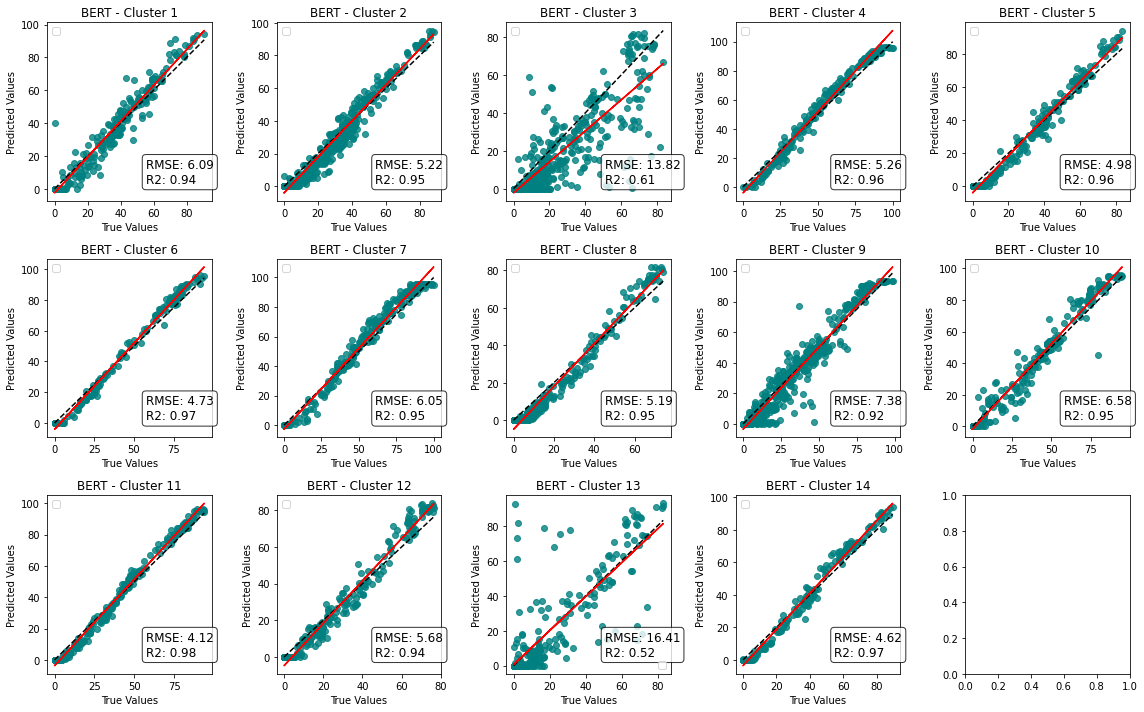

In [18]:
# Determine the number of rows and columns for the subplots layout
num_clusters = 15
num_rows = min(3, num_clusters)  # Maximum 3 rows
num_cols = (num_clusters + num_rows - 1) // num_rows

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10), gridspec_kw={'width_ratios': [1]*num_cols})


# Flatten the axs array to make it easier to iterate over all subplots
axs = axs.flatten()

for cluster in cluster_checkpoint:
    
    train = df[df["Cluster"]!=cluster]
    train_df=train.sample(frac=0.8,random_state=200)
    test = df[df["Cluster"]==cluster]
    
    train_df = train_df[["rxn", "YIELD"]]
    test_df = test[["rxn", "YIELD"]]
    
    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    mean = train_df.labels.mean()
    std = train_df.labels.std()
    
    train_df['labels'] = (train_df['labels'] - mean) / std

    model_path = f'./outputs_buchwald_hartwig_cross_val_project_cluster_{cluster}/checkpoint-{cluster_checkpoint[cluster]*30}-epoch-30'
    model = SmilesClassificationModel('bert', model_path,
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())
   
    y_preds = model.predict(test_df.text.values)[0]
    
    y_preds = y_preds * std + mean
    
    y_preds = np.clip(y_preds, 0, 100)
    
    # Calculate the row and column indices for the current subplot
    row = cluster // num_cols
    col = cluster % num_cols
    
    # Call the plotting function for each cluster with the respective subplot
    plot_model(axs[cluster], test_df['labels'], y_preds, title=None)#f"Cluster {cluster+1}")
    
    # Set labels and title for each subplot
    axs[cluster].set_xlabel('True Values')
    axs[cluster].set_ylabel('Predicted Values')
    axs[cluster].set_title(f'BERT - Cluster {cluster+1}')
    
    # Add legend to each subplot

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot
plt.savefig("./combined_plots_drfp_clusters.png", dpi=300)

plt.show()

In [21]:
string = "checkpoint-185-epoch-1"
string[11:14]

'185'

In [23]:
import os

In [28]:
for cluster in df["Aryl halide"].unique():
    
    folder_path = f'./outputs_buchwald_hartwig_cross_val_project_cluster_{cluster}'
    # Get a list of all directories in the folder and their creation timestamps
    directories = [dir_name for dir_name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, dir_name))]
    dir_timestamps = [(directory, os.path.getctime(os.path.join(folder_path, directory))) for directory in directories]
    oldest_directory = min(dir_timestamps, key=lambda x: x[1])[0]
    
    cluster_checkpoint = int(oldest_directory[11:14])
    
    train = df[df["Aryl halide"]!=cluster]
    train_df=train.sample(frac=0.8,random_state=200)
    test = df[df["Aryl halide"]==cluster]
    
    train_df = train_df[["rxn", "YIELD"]]
    test_df = test[["rxn", "YIELD"]]
    
    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    mean = train_df.labels.mean()
    std = train_df.labels.std()
    
    train_df['labels'] = (train_df['labels'] - mean) / std
    
    model_path = f'./outputs_buchwald_hartwig_cross_val_project_cluster_{cluster}/checkpoint-{cluster_checkpoint*30}-epoch-30'
    model = SmilesClassificationModel('bert', model_path,
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())
   
    y_preds = model.predict(test_df.text.values)[0]
    
    y_preds = y_preds * std + mean
    
    y_preds = np.clip(y_preds, 0, 100)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_model(ax, test_df['labels'], y_preds, title=f"{cluster}")
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Model Performance - Cluster {cluster}')
    plt.savefig(f"cluster_{cluster}_plot.png", dpi=300)
    plt.close(fig)

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/262 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [39]:
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem import Draw
from rdkit import Chem

In [44]:
# Define the plotting function
def plot_model(ax, y_true, y_predicted, title, smiles):
    print(smiles)
    # Calculate RMSE and R2 coefficients
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
    r2 = r2_score(y_true, y_predicted)

    # Plot the data
    ax.scatter(y_true, y_predicted, label=title, color='teal', alpha=0.8)

    # Plot the diagonal line
    ax.plot([0, 100], [0, 100], color='black', linestyle='--')

    # Plot the fitting line
    fitting_line = np.polyfit(y_true, y_predicted, 1)
    ax.plot(y_true, np.polyval(fitting_line, y_true), color='r')

    # Display RMSE and R2 coefficients in the plot
    text = f'RMSE: {rmse:.2f}\nR2: {r2:.2f}'
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    ax.text(0.6, 0.1, text, transform=ax.transAxes, fontsize=12, bbox=props)

    # Generate the RDKit molecule from the SMILES string
    mol = Chem.MolFromSmiles(smiles)

    opts = Draw.MolDrawOptions()
    opts.bondLineWidth = 4
    opts.baseFontSize = 1.0
    # Draw the molecule as an inset in the top left corner
    img = Draw.MolToImage(mol, size=(200, 200), kekulize=True, options=opts)

    inset_width = 0.2 * 1.2
    inset_height = 0.2 * 1.2
    ax_inset = ax.inset_axes([0.05, 0.75, inset_width, inset_height], transform=ax.transAxes)
    ax_inset.imshow(img)
    ax_inset.axis('off')


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

IC1=CC=C(OC)C=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

IC1=CC=C(C(F)(F)F)C=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

ClC1=CC=C(OC)C=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

BrC1=CC=C(OC)C=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

BrC1=CC=C(C(F)(F)F)C=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

IC1=CN=CC=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

BrC1=CN=CC=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

BrC1=CC=C(CC)C=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

BrC1=NC=CC=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

ClC1=CN=CC=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

IC1=NC=CC=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/262 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

ClC1=CC=C(CC)C=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

IC1=CC=C(CC)C=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

ClC1=NC=CC=C1


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

ClC1=CC=C(C(F)(F)F)C=C1


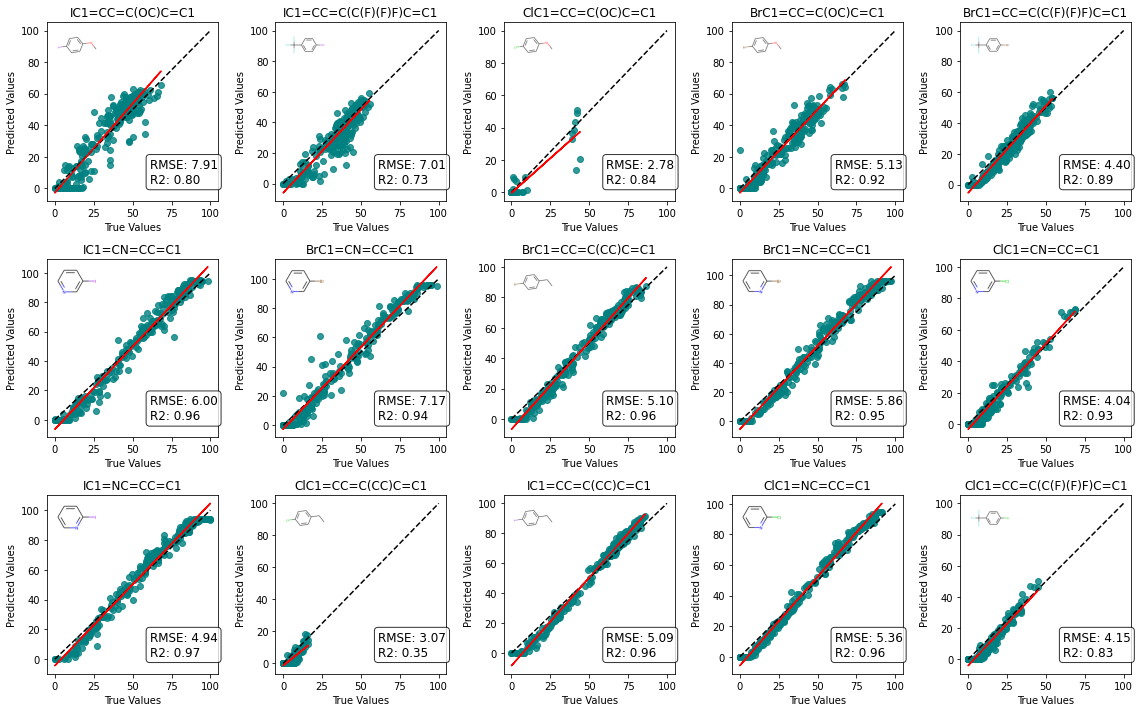

In [45]:
# Determine the number of rows and columns for the subplots layout
num_clusters = 15
num_rows = min(3, num_clusters)  # Maximum 3 rows
num_cols = (num_clusters + num_rows - 1) // num_rows

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10), gridspec_kw={'width_ratios': [1]*num_cols})


# Flatten the axs array to make it easier to iterate over all subplots
axs = axs.flatten()

for i, cluster in enumerate(df["Aryl halide"].unique()):
    
    folder_path = f'./outputs_buchwald_hartwig_cross_val_project_cluster_{cluster}'
    # Get a list of all directories in the folder and their creation timestamps
    directories = [dir_name for dir_name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, dir_name))]
    dir_timestamps = [(directory, os.path.getctime(os.path.join(folder_path, directory))) for directory in directories]
    oldest_directory = min(dir_timestamps, key=lambda x: x[1])[0]
    
    cluster_checkpoint = int(oldest_directory[11:14])
    
    train = df[df["Aryl halide"]!=cluster]
    train_df=train.sample(frac=0.8,random_state=200)
    test = df[df["Aryl halide"]==cluster]
    
    train_df = train_df[["rxn", "YIELD"]]
    test_df = test[["rxn", "YIELD"]]
    
    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    mean = train_df.labels.mean()
    std = train_df.labels.std()
    
    train_df['labels'] = (train_df['labels'] - mean) / std

    model_path = f'./outputs_buchwald_hartwig_cross_val_project_cluster_{cluster}/checkpoint-{cluster_checkpoint*30}-epoch-30'
    model = SmilesClassificationModel('bert', model_path,
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())
   
    y_preds = model.predict(test_df.text.values)[0]
    
    y_preds = y_preds * std + mean
    
    y_preds = np.clip(y_preds, 0, 100)
    
    # Calculate the row and column indices for the current subplot
    row = i // num_cols
    col = i % num_cols
    
    # Call the plotting function for each cluster with the respective subplot
    plot_model(axs[i], test_df['labels'], y_preds, "", cluster)
    
    # Set labels and title for each subplot
    axs[i].set_xlabel('True Values')
    axs[i].set_ylabel('Predicted Values')
    axs[i].set_title(f'{cluster}')
    
    # Add legend to each subplot

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot
plt.savefig("./combined_plots_aryl_clusters.png", dpi=300)

plt.show()